# Dual SVM

This notebook is a Python implementation of the dual SVM exercise.

The data files used in this notebook can be donwloaded from our course's Moodle page.

In [65]:
import matplotlib.pyplot as plt  # for plotting
import numpy as np  # for number manipulation
import cvxpy as cp  # for solving convex programs

## Importing and Plotting the Data

Below we provide two helper functions: the first one imports a data set from a file, and the second one plots a data set and the output of a classifier (within the unit square). These functions are similar to those implemented in the SVM notebook, but store the data set in a different format: rather than dealing with blue and red points separately, instead it is more convenient to work with the list of points and the list of their labels. Refer to the SVM notebook for more details.

In [66]:
# Reads data from file and returns lists of labels and points
def parse_points_labels(filename):
    # Reserve empty lists 
    points = []
    labels = []

    # Read data points from file
    with open(filename) as file:  # open desired file
        for line in file:  # read file line by line
            # Convert line into list of floats
            words = line.strip().split(' ')  # split into words by whitespaces, ignoring trailing whitespaces
            float_vector = [float(word) for word in words]  # convert strings into floats
            
            # Add data to lists
            points.append(float_vector[1:])
            labels.append(float_vector[0])

    # Print out imported data
    print(f'Points: {points}\n\nLabels: {labels}\n')
    
    # Return generated lists
    return points, labels



In [67]:
# Implements dummy classifier used by default by plotting function
def default_classifier(x, y):
    return x >= 0

# Plots data points and region identified as blue by classifier
def plot_data_with_classifier(points=[[0, 0], [0, 0]], labels=[1, -1], classifier=default_classifier):
    # Create canvas for plot
    fig = plt.figure(figsize=(10, 10), dpi=80)
    fig.subplots_adjust(0, 0, 1, 1)
    
    # Plot blue region generated by classifier
    x_values = np.linspace(0, 1, 1000)
    y_values = np.linspace(0, 1, 1000)
    x, y = np.meshgrid(x_values, y_values)
    blue_region = (classifier(x, y))
    plt.imshow(blue_region, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='Blues', alpha=0.3)
    
    # Plot data points
    blue_points = np.array([point for point, label in zip(points, labels) if label == 1])  # note that there are many ways to rearrange points into blue and red lists
    red_points = np.array([points[i] for i in range(len(points)) if labels[i] == -1])
    plt.scatter(blue_points[:, 0], blue_points[:, 1], marker='.', color='blue')
    plt.scatter(red_points[:, 0], red_points[:, 1], marker='.', color='red')
    
    # Display resulting image
    plt.show()

## Implementing the Dual SVM via a Convex Program

Now we implement the dual SVM via the convex program described in Section 3.8.1 of the script. The interface to the SVM function is as follows: it takes the lists of blue and red points as arguments and returns a classifier function. (As in the SVM notebook, a classifier function takes a data point as input and returns True or False depending on the side of the line it lies on.)

Note the following:

* For performance purposes, it is recommended to use CVXPY's atomic function `cp.quad_form` instead of implementing the sum by hand.
* If the matrix defining the quadratic form is positive semidefinite, the quadratic form is a convex function. However, there is a potential numerical issue: it might happen that because of to machine precision some eigenvalues of the matrix become slightly negative instead of slightly positive, making the quadratic form non-convex. To counteract this problem, we add a small constant to all diagonal entries, so that all eigenvalues are slightly increased. Naturally, one needs to choose the constant depending on the instance: if it is too small, some eigenvalues might end up being negative; if it is too large, the accuracy of the result might suffer.
* One can verify that in the optimal solution most of the dual variables are zeros, with non-vanishing (i.e., numerically relatively large) variables corresponding to the support vectors.

In [68]:
def compute_bias(points, labels, lambd, w):
    y = labels
    X = points
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == -1)[0]
    b_pos = np.min([1 - w @ X[i] for i in pos_idx])
    b_neg = np.max([-1 - w @ X[i] for i in neg_idx])
    return 0.5 * (b_pos + b_neg)


def Dual_SVM(points, labels):
    points = np.array(points)
    labels = np.array(labels)
    m = len(labels)

    lambd = cp.Variable(m, nonneg=True)

    # Costruzione matrice Q
    K = points @ points.T
    Y = np.outer(labels, labels)
    epsilon = 1e-1
    Q_np = np.multiply(Y, K) + epsilon * np.eye(m)
    Q_np = 0.5 * (Q_np + Q_np.T)  # forza simmetria
    Q = cp.Constant(Q_np) 

    # Obiettivo duale
    objective = cp.Maximize(cp.sum(lambd) - (1/4) * cp.quad_form(lambd, Q))
    constraints = [lambd @ labels == 0]

    # Risoluzione
    prob = cp.Problem(objective, constraints)
    prob.solve()

    lambd = lambd.value

    # Calcolo w e b
    w = 0.5 * np.sum((lambd * labels)[:, np.newaxis] * points, axis=0)
    b = compute_bias(points, labels, lambd, w)


    # Classificatore
    def classifier(x, y):
        pts = np.stack([x, y], axis=-1)
        return (pts @ w + b) >= 0

    return classifier


Now we test our implementation.

Points: [[0.8007445686755367, 0.9682615757193975], [0.8763891522960383, 0.8946066635038473], [0.9578895301505019, 0.5331652849730171], [0.6918771139504734, 0.31551563100606295], [0.6865009276815837, 0.8346256718973729], [0.417022004702574, 0.7203244934421581], [0.00011437481734488664, 0.30233257263183977], [0.14675589081711304, 0.0923385947687978], [0.1862602113776709, 0.34556072704304774], [0.39676747423066994, 0.538816734003357], [0.4191945144032948, 0.6852195003967595], [0.20445224973151743, 0.8781174363909454], [0.027387593197926163, 0.6704675101784022], [0.41730480236712697, 0.5586898284457517], [0.14038693859523377, 0.1981014890848788], [0.31342417815924284, 0.6923226156693141], [0.08504421136977791, 0.03905478323288236], [0.1698304195645689, 0.8781425034294131], [0.0983468338330501, 0.42110762500505217], [0.018288277344191806, 0.7501443149449675]]

Labels: [1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]

20


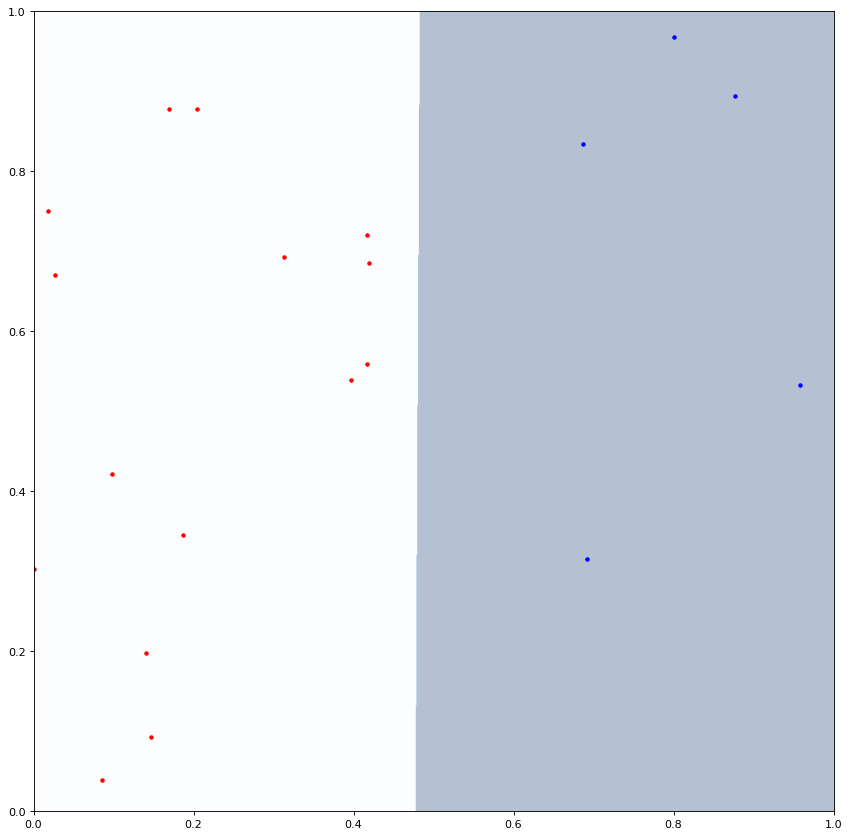

In [73]:
# Load data from file
points, labels = parse_points_labels('Dual_SVM_data_1.txt')  # filename can be from 'Dual_SVM_data_1.txt' to 'Dual_SVM_data_6.txt'
print(len(labels))

# Get classifier from SVM
classifier = Dual_SVM(points, labels)

# Visually check output of classifier
plot_data_with_classifier(points, labels, classifier)

## Kernels

Now we implement dual SVMs that support kernels. The interface to the SVM function is similar, with the only difference being that we pass the function defining the kernel as the last parameter.

Note that the key difference in the realizations of dual SVMs with and without kernels is that dot products are replaced by corresponding kernels.

In [74]:
import numpy as np
import cvxpy as cp

def Dual_SVM_with_kernel(points, labels, kernel):
    points = np.array(points)
    labels = np.array(labels)
    m = len(labels)

    # Variabili duali
    lambd = cp.Variable(m, nonneg=True)

    # Costruzione matrice di Gram kernelizzata
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = kernel(points[i], points[j])
    Y = np.outer(labels, labels)
    Q = np.multiply(Y, K) + 1e-6 * np.eye(m)
    Q = 0.5 * (Q + Q.T)
    Q = cp.Constant(Q)

    # Risolvi problema duale
    objective = cp.Maximize(cp.sum(lambd) - (1/4) * cp.quad_form(lambd, Q))
    constraints = [lambd @ labels == 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    lambd_val = lambd.value

    # Calcolo b con margini (come prima)
    def compute_bias_kernel():
        pos_idx = np.where(labels == 1)[0]
        neg_idx = np.where(labels == -1)[0]

        def f_raw(x):
            return np.sum(lambd_val * labels * np.array([kernel(p, x) for p in points]))

        b_pos = np.min([1 - f_raw(points[i]) for i in pos_idx])
        b_neg = np.max([-1 - f_raw(points[i]) for i in neg_idx])
        return 0.5 * (b_pos + b_neg)

    b = compute_bias_kernel()

    # Classificatore: accetta x, y (array o meshgrid)
    def classifier(x, y):
        test_points = np.stack([x, y], axis=-1)
        result = np.zeros(test_points.shape[:-1])
        for i in range(test_points.shape[0]):
            for j in range(test_points.shape[1]):
                x_test = test_points[i, j]
                score = np.sum(lambd_val * labels * np.array([kernel(p, x_test) for p in points])) + b
                result[i, j] = score >= 0
        return result.astype(bool)

    return classifier


Below you can find implementations of three example kernels.

In [75]:
def kernel_1(p, q):
    return np.square((p[0] - 0.5) * (q[0] - 0.5) + (p[1] - 0.5) * (q[1] - 0.5))

def kernel_2(p, q):
    return p[0] * q[0] + p[1] * q[1] + np.square((p[1] - 0.5) * (q[1] - 0.5))

def kernel_3(p,q) :
    return np.square(p[0] * q[0] + p[1] * q[1])

Now we test our classifier on the additional data sets.

Points: [[0.5496624778787091, 0.4353223926182769], [0.42036780208748903, 0.3303348210038741], [0.2046486340378425, 0.6192709663506637], [0.29965467367452314, 0.26682727510286663], [0.6211338327692949, 0.5291420942770391], [0.2203062070705597, 0.34982628500329926], [0.46778748458230024, 0.20174322626496533], [0.6404067252149148, 0.48306983555175165], [0.5052367200185491, 0.3868926511185593], [0.7936374544415771, 0.5800041788778066], [0.5671441276277093, 0.42754596329611005], [0.436747263026799, 0.7765591849971003], [0.43599490214200376, 0.025926231827891333], [0.13457994534493356, 0.5135781212657464], [0.18443986564691528, 0.7853351478166735], [0.8539752926394888, 0.4942368373819278], [0.846561485357468, 0.079645477009061], [0.505246090121704, 0.06528650438687811], [0.42812232759738944, 0.09653091566061256], [0.12715997170127746, 0.5967453089785958], [0.22601200060423587, 0.10694568430998297], [0.16229859850231387, 0.7007523466071562], [0.9645510800892552, 0.5000083611702167], [0.889520

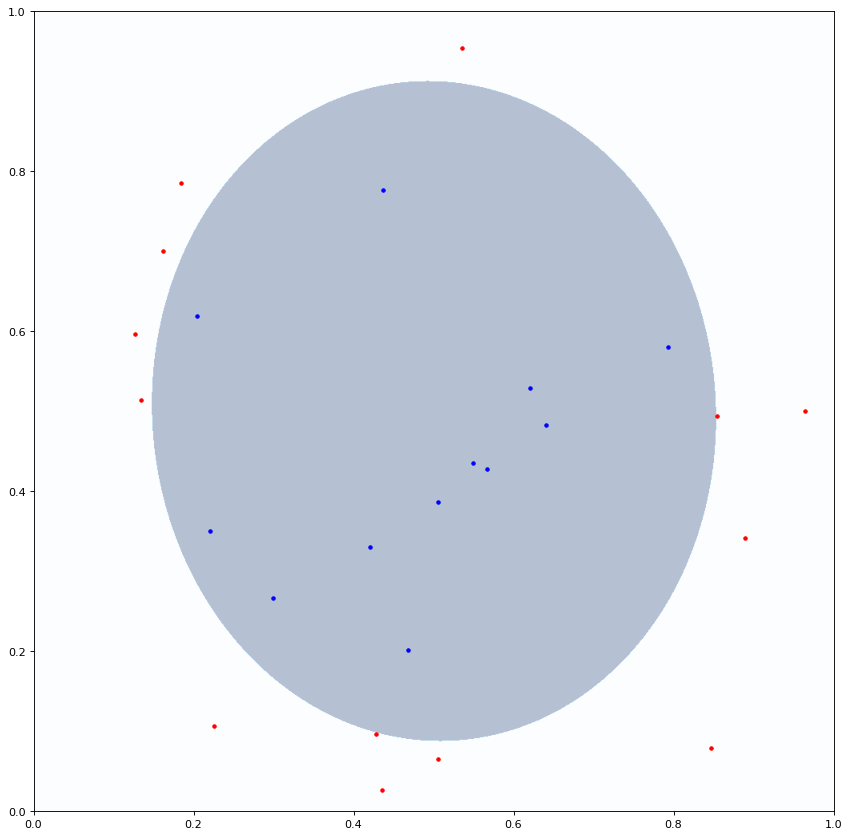

In [79]:
# Load data from file
points, labels = parse_points_labels('Dual_SVM_kernel_1.txt')  # filename can be from 'Dual_SVM_kernel_1.txt' to 'Dual_SVM_kernel_3.txt'

# Get classifier from SVM
classifier_kernel_1 = Dual_SVM_with_kernel(points, labels, kernel_1)  # kernel can be from kernel_1 to kernel_3

# Visually check output of classifier
plot_data_with_classifier(points, labels, classifier_kernel_1)